Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face
Loaded model from C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face\79999_iter.pth
part_mask shape (512, 512)
binary_skin_mask_stacked shape (512, 512, 3)
image shape (512, 512, 3)
part_mask shape (512, 512)
binary_skin_mask_stacked shape (512, 512, 3)
image shape (512, 512, 3)
skin shape (512, 512, 3)


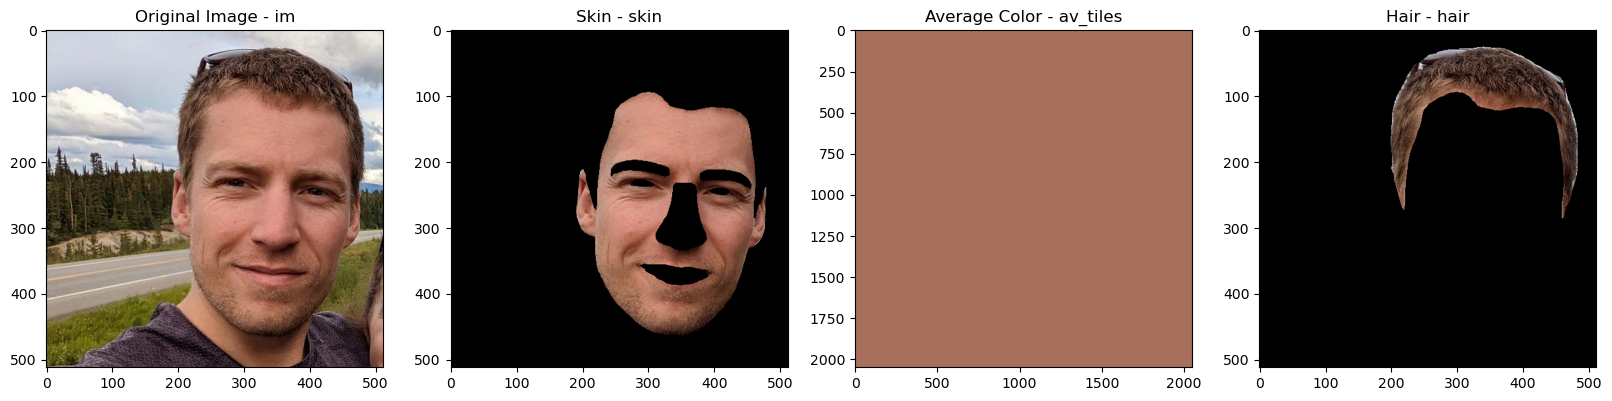

In [14]:
import sys

import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pickle
import importlib
import torch_face
from torch_face import face_part_segmentation as fps
importlib.reload(torch_face)
im_path = r"C:\Desktop\joel.jpg"
im = Image.open(im_path)
im = im.convert('RGB')
im = np.array(im)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
combined = ['l_ear', 'r_ear','skin', 'mouth', 'nose']
segmenter = fps.FacePartSegmentation(width=2048, height=2048)
part_mask = segmenter.process_image(im, combined)
skin, mask = segmenter.get_skin(im)
av_skin_tile = segmenter.get_skin_tile(im)
hair = segmenter.get_hair(im)
ax[0].imshow(im)
ax[0].set_title('Original Image - im')
ax[1].imshow(part_mask)
ax[1].set_title('Part Mask - part_mask')
ax[1].imshow(skin)
ax[1].set_title('Skin - skin')
ax[2].imshow(av_skin_tile.astype(np.uint8))
ax[2].set_title('Average Color - av_tiles')
ax[3].imshow(part_mask)
ax[3].set_title('Part Mask - part_mask')
ax[3].imshow(hair)
ax[3].set_title('Hair - hair')
plt.show()

skin_mask = segmenter.process_image

GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference
Current Working Directory: C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face
CUDAExecutionProvider available. Using GPU.
Loaded model from C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face\79999_iter.pth
part_mask shape (2048, 2048)
binary_skin_mask_stacked shape (2048, 2048, 3)
image shape (2048, 2048, 3)


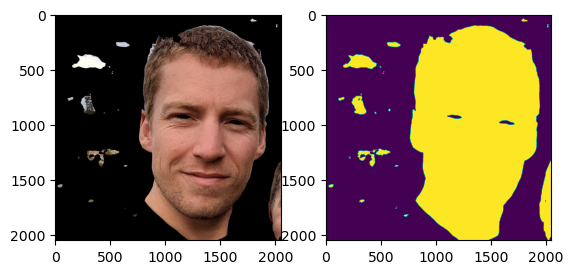

c:\Users\joeli\miniforge3\envs\torch_311\Lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


part_mask shape (2048, 2048)
binary_skin_mask_stacked shape (2048, 2048, 3)
image shape (2048, 2048, 3)


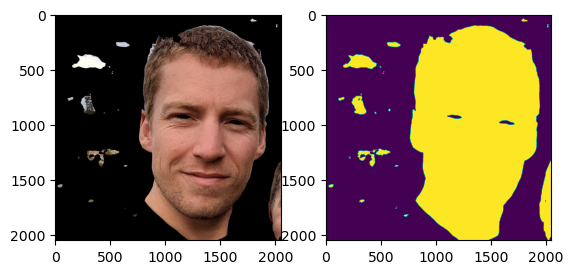

skin shape (2048, 2048, 3)
Time to encode: 0.610447883605957
Time to decode: 0.6110410690307617
(1, 4194304, 3)
float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


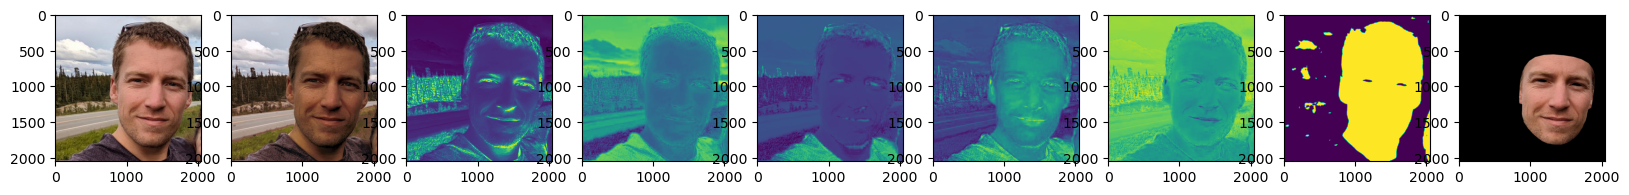

In [1]:
import numpy as np
import onnxruntime as ort
print(ort.get_device())
print(ort.get_available_providers())
import onnx_inference
from onnx_inference import onnx_ae 
import os
# from PIL import Image
import sys
import torch
import os
import os.path as osp
import numpy as np
import time
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pickle
import importlib
import torch_face
from torch_face import face_part_segmentation as fps
sys.path.append("segmentation")
import segmentation as seg
importlib.reload(seg)
def increase_values(encoded, alpha=1.0, beta=0.1):
    """
    Increases the values in the latent space representation.

    :param encoded: The latent space representation.
    :param alpha: Scale factor for the increase.
    :param beta: Bias for the increase.
    :return: Modified latent space representation.
    """
    return encoded * alpha + beta

def modify_latent_space_for_skin(encoded_data, mask, modification_function, *args, **kwargs):
    """
    Modifies the latent space representation for skin areas in the image.

    :param encoded_data: Encoded representation of the image (latent space).
    :param mask: A binary mask indicating skin areas (1 for skin, 0 for non-skin).
    :param modification_function: A function that modifies the latent space representation.
    :param args: Additional arguments for the modification function.
    :param kwargs: Additional keyword arguments for the modification function.
    :return: Modified latent space representation.
    """
    if mask.ndim == 3:
        mask = mask[:, :, 0]  # Assume the mask is the same for all channels
    # Ensure the mask is binary and match the shape of the latent space
    mask = mask.reshape(encoded_data.shape)
    mask = np.where(mask > 0, 1, 0)

    # Apply modification to the skin areas in latent space
    modified_encoded = modification_function(encoded_data, *args, **kwargs)

    # Combine the modified areas with the original latent space using the mask
    combined_encoded = np.where(mask == 1, modified_encoded, encoded_data)

    return combined_encoded

encoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_encoder.onnx"
decoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_decoder.onnx"
ae = onnx_ae.ONNXAutoencoder(encoder_path, decoder_path)
segmenter = fps.FacePartSegmentation(width=2048, height=2048)
im_path = r"C:\Desktop\joel.jpg"
im = cv2.imread(im_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (2048, 2048),interpolation=cv2.INTER_LANCZOS4)
skin, mask = segmenter.get_skin(im)
combined_mask, lips, eyes, nose, eye_bags, face,oxy_mask, landmark_object, av_skin_color = seg.create_combined_mask(im)

face = cv2.resize(face, (2048, 2048), interpolation=cv2.INTER_LANCZOS4)

face = cv2.bitwise_or(skin, skin, mask=face)
av_skin_tile = segmenter.get_skin_tile(im)
hair = segmenter.get_hair(im)

im = np.asarray(im).astype(np.float32).reshape(-1, 3)
if np.max(im) > 1.0:
    im = im / 255.0
start = time.time()
encoded = ae.encode(im)
end = time.time()
print(f"Time to encode: {end-start}")
pm = np.asarray(encoded).astype(np.float32).reshape(2048, 2048, 5)
cm = pm[:,:,0]
ch = pm[:,:,1]
bm = pm[:,:,2]
bh = pm[:,:,3]
t = pm[:,:,4]
alpha = 1.8  # Scale factor
beta = 0.1   # Bias
cm_new = modify_latent_space_for_skin(cm, mask, increase_values, alpha, beta)

bm_new = modify_latent_space_for_skin(bm, mask, increase_values, alpha, beta)
pm = np.dstack((cm_new, ch, bm, bh, t))
encoded = np.asarray(pm).astype(np.float32)
encoded = encoded.reshape(-1, 5)
start = time.time()
decoded = ae.decode(encoded)
end = time.time()
print(f"Time to decode: {end-start}")
print(np.asarray(decoded).shape)
print(np.asarray(decoded).dtype)
decoded = np.asarray(decoded).astype(np.float32).reshape(2048, 2048, 3)
if np.max(decoded) < 1.0:
    decoded = decoded * 255.0
if np.max(im) < 1.0:
    im = im * 255.0

im = im.reshape(2048, 2048, 3)
av_skin_tile = av_skin_tile.astype(np.float32).reshape(2048, 2048, 3)
decoded = decoded.astype(np.float32).reshape(2048, 2048, 3)

if np.max(face) > 2:
    face = face / 255.0
if np.max(im) >2:
    im = im / 255.0
if np.max(decoded) >2:
    decoded = decoded / 255.0
if np.max(av_skin_tile) > 2:
    av_skin_tile = av_skin_tile / 255.0
fig, ax = plt.subplots(1, 9, figsize=(20, 10))
ax[0].imshow(im.reshape(2048, 2048, 3))
ax[1].imshow(decoded)
ax[2].imshow(cm)
ax[3].imshow(ch) 
ax[4].imshow(bm)
ax[5].imshow(bh)
ax[6].imshow(t)
ax[7].imshow(mask)
ax[8].imshow(face)
plt.show()

GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
CUDAExecutionProvider available. Using GPU.
Loaded model from C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\torch_face\79999_iter.pth
['C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053411.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053412.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_053415.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_1_ft_1_053077.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_2_ft_2_053021.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_2_ft_2_053426.png', 'C:\\Users\\joeli\\Dropbox\\Code\\Python Projects\\Texture_Image_Pipeline\\fitzpatrick\\ft_2_m141_4k.png', 'C:

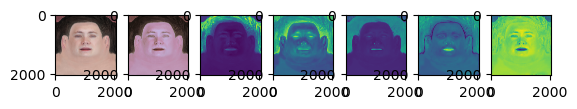

(1, 4194304, 3)
float32


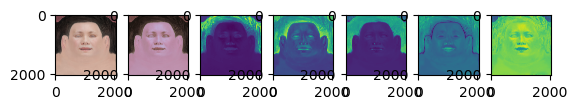

In [16]:
# !pip install onnxruntime
# !pip uninstall onnxruntime -y
# !pip install --user onnxruntime 
# !pip install --user onnxruntime-gpu

import numpy as np
import onnxruntime as ort
print(ort.get_device())
print(ort.get_available_providers())
import onnx_inference
from onnx_inference import onnx_ae 
import os
# from PIL import Image
import sys
import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import pickle
import importlib
import torch_face
from torch_face import face_part_segmentation as fps
encoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_encoder.onnx"
decoder_path = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\onnx_inference\small_batch_size_decoder.onnx"
ae = onnx_ae.ONNXAutoencoder(encoder_path, decoder_path)
image_dir = r"C:\Users\joeli\Dropbox\Code\Python Projects\Texture_Image_Pipeline\fitzpatrick"
image_paths  =  os.listdir(image_dir)
image_paths = [os.path.join(image_dir, im) for im in image_paths]
segmenter = fps.FacePartSegmentation(width=2048, height=2048)
print(image_paths)
# add im to image_paths
image_paths.append(im_path)
for im_path in image_paths[:2]:

    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (2048, 2048))
    im = np.asarray(im).astype(np.float32).reshape(-1, 3)
    im = im/255.0
    encoded = ae.encode(im)
    pm = np.asarray(encoded).astype(np.float32).reshape(2048, 2048, 5)
    cm = pm[:,:,0]
    ch = pm[:,:,1]+0.5
    bm = pm[:,:,2]
    bh = pm[:,:,3]+0.2
    t = pm[:,:,4]
    pm = np.dstack((cm, ch, bm, bh, t))
    encoded = np.asarray(pm).astype(np.float32)
    encoded = encoded.reshape(-1, 5)
    decoded = ae.decode(encoded)
    print(np.asarray(decoded).shape)
    print(np.asarray(decoded).dtype)
    decoded = np.asarray(decoded).astype(np.float32).reshape(2048, 2048, 3)
    fig, ax = plt.subplots(1, 7)
    ax[0].imshow(im.reshape(2048, 2048, 3))
    ax[1].imshow(decoded)
    ax[2].imshow(cm)
    ax[3].imshow(ch)
    ax[4].imshow(bm)
    ax[5].imshow(bh)
    ax[6].imshow(t)
    plt.show()
    